
# 📊 Stock Dashboard

This notebook fetches adjusted prices for **mega‑cap stocks** plus **VOO**, then computes:
- periodic returns (daily/weekly/monthly)
- cumulative growth of $1
- annualized return, volatility, Sharpe ratio
- max drawdown
- return correlation matrix

> Uses `yfinance` with `auto_adjust=True`, so `Close` reflects splits & dividends.


In [54]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, timedelta

pd.set_option('display.float_format', lambda v: f"{v:.6f}")

In [55]:
tickers = ["AAPL","MSFT","AMZN","NVDA","TSLA","VOO"]
end = date.today()
start = end - timedelta(days=365*1)  # For the last 2 years
interval = "1wk" # 1d, 1wk, 1mo, etc.

In [56]:
def load_prices(tickers, start, end, interval):
    df = yf.download(
        tickers,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=True,   # Adjust for stock splitting, dividends, etc.
        group_by="column",
        progress=False,
        threads=True,
    )

    if "Close" in df.columns and isinstance(df["Close"], pd.DataFrame):
        prices = df["Close"].copy()
    else:
        prices = df["Close"].to_frame(tickers[0])
    
    prices = prices.dropna(how="all")

    return prices

prices = load_prices(tickers, start, end, interval)
prices.tail()

Ticker,AAPL,AMZN,MSFT,NVDA,TSLA,VOO
Date,,,,,,
2025-09-15,245.500000,231.479996,517.929993,176.669998,426.070007,610.035400
2025-09-22,255.460007,219.779999,511.459991,178.190002,440.399994,608.419983
2025-09-29,258.019989,219.509995,517.349976,187.619995,429.829987,613.545349
2025-10-06,245.270004,216.369995,510.959991,183.160004,413.489990,600.510010
2025-10-13,247.660004,220.070007,514.049988,188.320007,435.899994,609.609985


In [57]:
# Helper Functions

def to_pct_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.pct_change().dropna()

def to_cumulative_growth(returns: pd.DataFrame) -> pd.DataFrame:
    return (1.0 + returns).cumprod()

def annualize_return(returns: pd.DataFrame, interval: str) -> pd.Series:
    if interval == "1d":
        scale = 252
    elif interval == "1wk":
        scale = 52
    else:
        scale = 12
    return returns.mean() * scale

def annualize_volatility(returns: pd.DataFrame, interval: str) -> pd.Series:
    if interval == "1d":
        scale = np.sqrt(252)
    elif interval == "1wk":
        scale = np.sqrt(52)
    else:
        scale = np.sqrt(12)
    return returns.std() * scale

def max_drawdown(prices: pd.DataFrame) -> pd.Series:
    dd = {}
    for c in prices.columns:
        p = prices[c].dropna()
        if p.empty:
            dd[c] = np.nan
            continue
        running_max = p.cummax()
        drawdown = p / running_max - 1.0
        dd[c] = drawdown.min()
    return pd.Series(dd)

In [58]:
returns = to_pct_returns(prices)
cum = to_cumulative_growth(returns)
ann_ret = annualize_return(returns, interval)
ann_vol = annualize_volatility(returns, interval)
sharpe = ann_ret / ann_vol.replace(0, np.nan)
mdd = max_drawdown(prices)

summary = pd.DataFrame({
    "Annual Return": ann_ret,
    "Volatility": ann_vol,
    "Sharpe": sharpe,
    "Max Drawdown": mdd
}).sort_values("Sharpe", ascending=False)

summary.style.format({
    "Annual Return": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe": "{:.2f}",
    "Max Drawdown": "{:.2%}",
})


,Annual Return,Volatility,Sharpe,Max Drawdown
TSLA,86.81%,62.71%,1.38,-45.11%
MSFT,23.90%,22.62%,1.06,-19.39%
NVDA,41.73%,46.34%,0.90,-36.11%
VOO,15.36%,17.22%,0.89,-16.69%
AMZN,19.58%,29.72%,0.66,-28.05%
AAPL,11.03%,32.76%,0.34,-26.21%


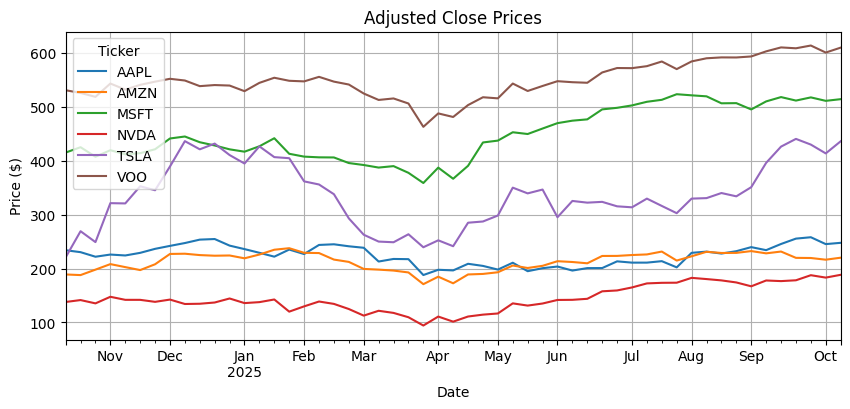

In [59]:
fig, ax = plt.subplots(figsize=(10,4))
prices.plot(ax=ax)
ax.set_title("Adjusted Close Prices")
ax.set_ylabel("Price ($)")
plt.grid(True)
plt.show()

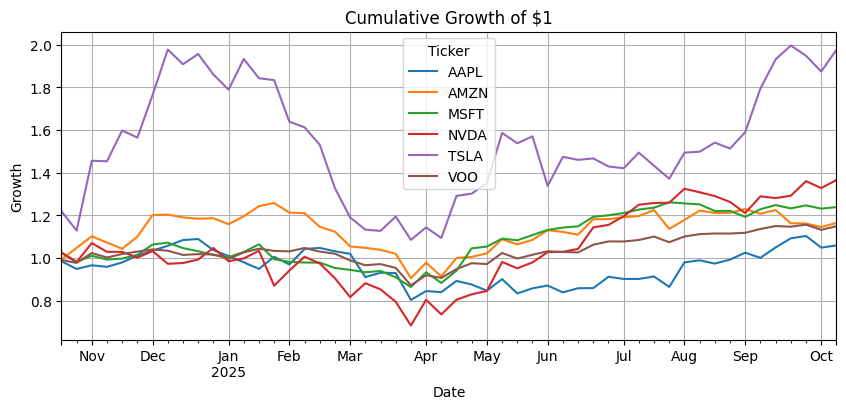

In [65]:
fig, ax = plt.subplots(figsize=(10,4))
cum.plot(ax=ax)
ax.set_title("Cumulative Growth of $1")
ax.set_ylabel("Growth")
plt.grid(True)
plt.show()

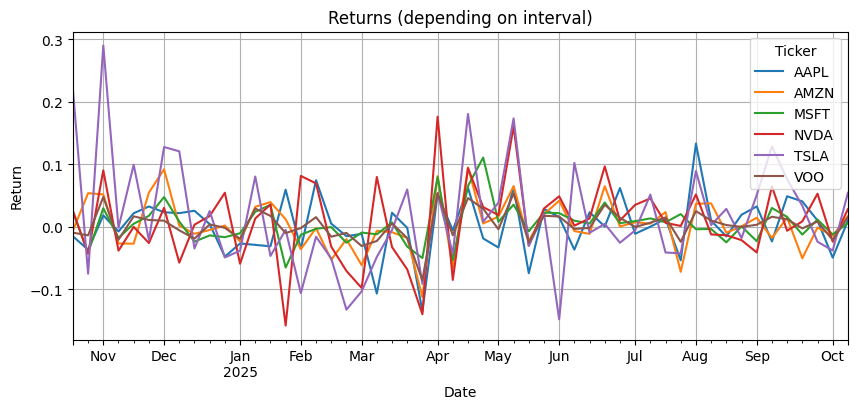

In [66]:
fig, ax = plt.subplots(figsize=(10,4))
returns.plot(ax=ax)
ax.set_title("Returns (depending on interval)")
ax.set_ylabel("Return")
plt.grid(True)
plt.show()

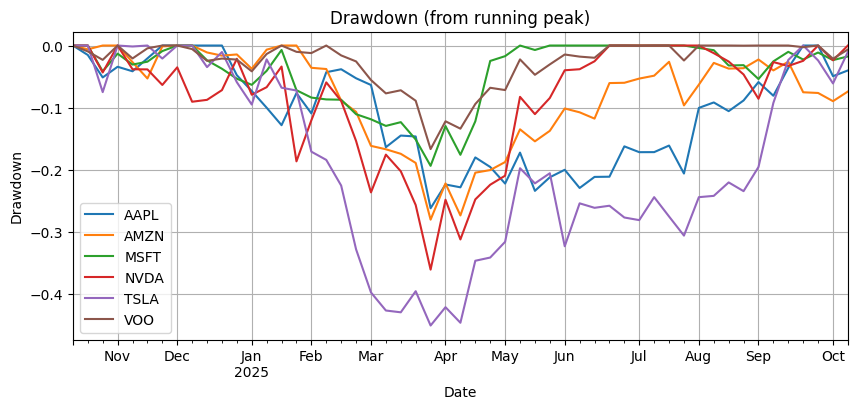

In [67]:
dd_curves = {}
for c in prices.columns:
    p = prices[c].dropna()
    if p.empty:
        continue
    dd_curve = p / p.cummax() - 1.0
    dd_curves[c] = dd_curve

if dd_curves:
    dd_df = pd.DataFrame(dd_curves).dropna(how="all")
    fig, ax = plt.subplots(figsize=(10,4))
    dd_df.plot(ax=ax)
    ax.set_title("Drawdown (from running peak)")
    ax.set_ylabel("Drawdown")
    plt.grid(True)
    plt.show()
else:
    print("No data for drawdown plot.")

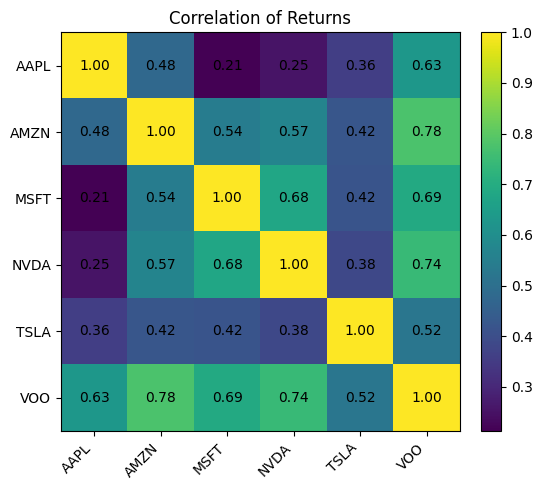

In [63]:
corr = returns.corr()

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)
ax.set_title("Correlation of Returns")

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()